# Distillation training

Restart the kernel after installing dependencies in the Notebook.

In [1]:
!pip install -q -U sentencepiece transformers datasets sacrebleu lxml sentence-transformers accelerate fastai

## Config, imports, etc.

In [2]:
RANDOM_SEED = 727  # Set `RANDOM_SEED = None` to run without a seed

In [3]:
from functools import partial
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from data import (
    load_from_json,
    TranslationDataset,
    create_dataloaders
)
from modeling import (
    load_model,
    create_learner,
    create_distillation_learner,
    prune
)
from utils import preproc, set_seed, cleanup
from translation import translate
from evaluation import calculate_bleu

In [4]:
if RANDOM_SEED is not None:
    set_seed(RANDOM_SEED, reproducible=True)

## STEP 1 - Fine-tune NLLB-200-600M with modified tokenizer

In [5]:
MODEL_ID = "facebook/nllb-200-distilled-600M"
TOKENIZER_ID = "tokenizers/tokenizer_freq5"

### Load training data

In [6]:
df = load_from_json(
    train_files="data/dataset_train.json",
    valid_files="data/dataset_validation.json",
    test_files="data/dataset_test.json",
    return_format="df"
)
print(df.shape)
df.head()

(10929, 3)


,dyu,fr,split
0,A bi ji min na,Il boit de l’eau.,train
1,A le dalakolontɛ lon bɛ.,Il se plaint toujours.,train
2,Mun? Fɛn dɔ.,Quoi ? Quelque chose.,train
3,O bɛ bi bɔra fo Gubeta.,Tous sortent excepté Gubetta.,train
4,A ale lo bi da bugɔ la!,Ah ! c’est lui… il sonne…,train


In [7]:
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

### Load model and remap tokenizer embeddings

In [8]:
model, tokenizer = load_model(
    MODEL_ID, load_tokenizer=True, tokenizer_id=TOKENIZER_ID, remap_embeddings=True, init_embeds_for_new_tokens=True,
    old_tokenizer_id=MODEL_ID, src_language="dyu_Latn", tgt_language="fra_Latn"
)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Number of tokens w/o embeddings: 1
model.shared.weight torch.Size([256206, 1024])
model.encoder.embed_tokens.weight torch.Size([256206, 1024])
model.decoder.embed_tokens.weight torch.Size([256206, 1024])
lm_head.weight torch.Size([256206, 1024])
Memory footprint: 1.34GB


### Create dataloaders, learner, and train model

In [9]:
dls = create_dataloaders(
    df_train[["dyu", "fr"]], df_valid[["dyu", "fr"]], tokenizer, bs=32,
    src_lang="dyu_Latn", tgt_lang="fra_Latn", preproc_func=preproc,
    max_length=128
)

In [10]:
learn = create_learner(dls, model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn")#, wd=1e-3)

SuggestedLRs(valley=0.00019054606673307717)

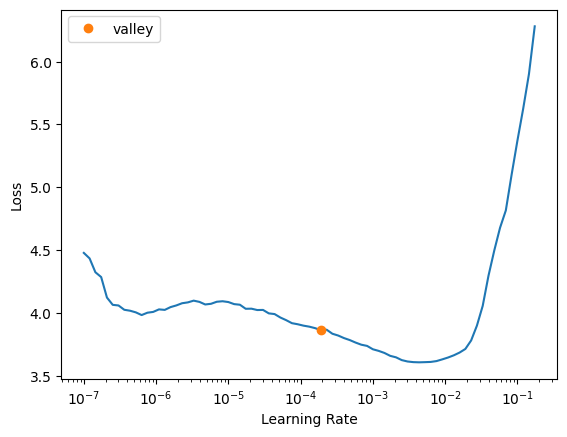

In [11]:
learn.lr_find()

In [12]:
learn.fit_flat_cos(10, lr=1e-4, div_final=100_000.0, pct_start=0.75)

epoch,train_loss,valid_loss,BLEU,time
0,2.411686,2.358787,7.401550,01:01
1,1.971459,2.247160,9.289808,01:01
2,1.696689,2.214976,9.530438,01:02
3,1.480137,2.256786,10.103760,01:02
4,1.201818,2.312543,10.259213,01:02
5,1.073864,2.377290,11.049601,01:02
6,0.919081,2.467158,10.747728,01:02
7,0.784801,2.509850,10.436489,01:03
8,0.643235,2.614029,11.182913,01:02
9,0.588407,2.638335,10.944775,01:03


In [13]:
translate_func = partial(
    translate, model=model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

10.917649583377022

In [14]:
MODEL_SAVE_PATH = 'saved_models/dyu-fra-vocab-freq5'
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

[2024-09-01 08:29:31,702] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('saved_models/dyu-fra-vocab-freq5/tokenizer_config.json',
 'saved_models/dyu-fra-vocab-freq5/special_tokens_map.json',
 'saved_models/dyu-fra-vocab-freq5/sentencepiece.bpe.model',
 'saved_models/dyu-fra-vocab-freq5/added_tokens.json')

## STEP 2 - Down-scale and train again

 - Reduce the number of encoder and decoder layers by a factor of two (12 layers -> 6 layers)
 - Reduce the dimensions of embdding and linear layers by a factor of 2
 - Use teacher-student distillation training to train the down-scaled model

In [15]:
BASE_MODEL_ID = "saved_models/dyu-fra-vocab-freq5"

### Load training data

In [16]:
df = load_from_json(
    train_files=[
        "data/dataset_train.json",
        "data/dataset_bt_train.json",
        "data/dataset_bt_test.json",
        # "data/dataset_validation.json", "data/dataset_bt_validation.json"
    ],
    valid_files="data/dataset_validation.json",
    test_files="data/dataset_test.json",
    return_format="df"
)
print(df.shape)
df.head()

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

(74017, 3)


,dyu,fr,split
0,A bi ji min na,Il boit de l’eau.,train
1,A le dalakolontɛ lon bɛ.,Il se plaint toujours.,train
2,Mun? Fɛn dɔ.,Quoi ? Quelque chose.,train
3,O bɛ bi bɔra fo Gubeta.,Tous sortent excepté Gubetta.,train
4,A ale lo bi da bugɔ la!,Ah ! c’est lui… il sonne…,train


In [17]:
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

### Load/instantiate models

Load the teacher model:

In [18]:
tokenizer = NllbTokenizer.from_pretrained(BASE_MODEL_ID)
teacher_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_ID, device_map="cuda")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1024**3 :.2f}GB")

Memory footprint: 1.34GB


Create the student model as a pruned version of the teacher:

In [19]:
student_model = prune(teacher_model, size_factor=2, layer_size_factor=2, dim_strategy="alternate", layer_strategy="alternate")

Memory footprint: 0.17GB


### Create dataloaders and train

In [20]:
dls = create_dataloaders(
    df_train[["dyu", "fr"]], df_valid[["dyu", "fr"]], tokenizer, bs=256,
    src_lang="dyu_Latn", tgt_lang="fra_Latn", preproc_func=preproc,
    max_length=128
)

In [21]:
learn = create_distillation_learner(
    dls, student_model, teacher_model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)

SuggestedLRs(valley=0.0008317637839354575)

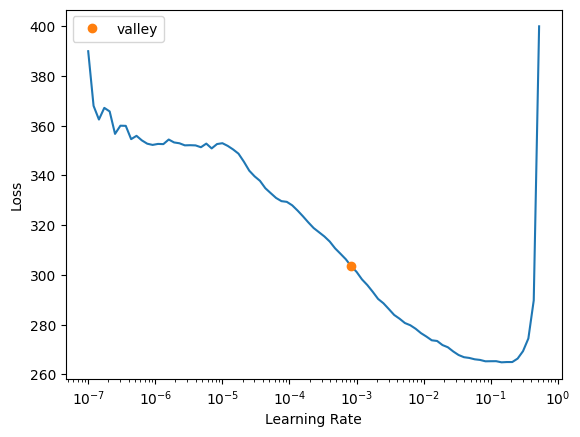

In [22]:
learn.lr_find()

In [23]:
learn.fit_sgdr(5, 1, cycle_mult=2, lr_max=1e-3)

epoch,train_loss,valid_loss,BLEU,time
0,190.155365,176.570526,0.044542,03:17
1,171.794891,158.197845,0.473244,03:18
2,162.892990,151.593796,0.508094,03:18
3,156.048859,145.747543,1.027050,03:17
4,148.138916,141.051193,1.942593,03:17
5,144.127289,138.705307,2.378448,03:18
6,144.674164,137.950623,2.545489,03:17
7,142.739334,137.370026,3.648202,03:18
8,137.093414,133.952057,5.659556,03:16
9,137.559265,131.593170,6.889184,03:18


In [24]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

9.612240553469217

In [25]:
MODEL_SAVE_PATH = './tmp'
student_model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('./tmp/tokenizer_config.json',
 './tmp/special_tokens_map.json',
 './tmp/sentencepiece.bpe.model',
 './tmp/added_tokens.json')

In [26]:
del teacher_model, student_model
cleanup()

## STEP 3 - Down-scale for the last time

 - Use the model from Step 2 as the teacher
 - Reduce the number of encoder and decoder layers by a factor of two (6 layers -> 3 layers)
 - Reduce the dimensions of embdding and linear layers by a factor of 2
 - Use teacher-student distillation training to train the down-scaled model

### Load the teacher and student models:

In [27]:
BASE_MODEL_ID = "./tmp"
tokenizer = NllbTokenizer.from_pretrained(BASE_MODEL_ID)
teacher_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_ID, device_map="cuda")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1024**3 :.2f}GB")
student_model = prune(
    teacher_model, size_factor=2, layer_size_factor=2, dim_strategy="alternate", layer_strategy="alternate"
)

Memory footprint: 0.17GB
Memory footprint: 0.02GB


### Create `Learner` and train:

In [28]:
learn = create_distillation_learner(
    dls, student_model, teacher_model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)

In [29]:
learn.fit_sgdr(5, 1, cycle_mult=2, lr_max=1e-3)

epoch,train_loss,valid_loss,BLEU,time
0,161.386353,145.436066,0.040205,00:48
1,141.510590,126.587967,0.734485,00:48
2,136.791504,123.630386,1.833860,00:48
3,128.055130,118.531044,3.083235,00:48
4,123.868584,115.380203,4.720419,00:49
5,120.333290,114.051071,5.439855,00:48
6,120.836754,113.733322,5.349638,00:49
7,119.155739,113.323608,6.211331,00:48
8,119.090385,111.878990,6.629793,00:49
9,116.143425,110.914940,6.739334,00:49


In [30]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

8.32036716982674

In [31]:
MODEL_SAVE_PATH = 'saved_models/nllb-dyu-fr-distilled'
student_model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('saved_models/nllb-dyu-fr-distilled/tokenizer_config.json',
 'saved_models/nllb-dyu-fr-distilled/special_tokens_map.json',
 'saved_models/nllb-dyu-fr-distilled/sentencepiece.bpe.model',
 'saved_models/nllb-dyu-fr-distilled/added_tokens.json')

## Finally, fine-tune on the original training data only:

### Load data

In [32]:
df = load_from_json(
    train_files="data/dataset_train.json",
    valid_files="data/dataset_validation.json",
    test_files="data/dataset_test.json",
    return_format="df"
)
df_train = df[df["split"] == "train"].copy()
df_valid = df[df["split"]== "validation"].copy()
df_test = df[df["split"]== "test"].copy()
assert len(df_train) + len(df_valid) + len(df_test) == len(df)

### Create dataloaders and train

In [33]:
dls = create_dataloaders(
    df_train[["dyu", "fr"]], df_valid[["dyu", "fr"]], tokenizer, bs=128,
    src_lang="dyu_Latn", tgt_lang="fra_Latn", preproc_func=preproc,
    max_length=128
)
learn = create_learner(dls, student_model, tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn")

In [34]:
learn.fit_flat_cos(10, 1e-5)

epoch,train_loss,valid_loss,BLEU,time
0,1.340048,2.879955,8.018981,00:04
1,1.320090,2.873580,8.208049,00:04
2,1.340485,2.865332,8.165605,00:04
3,1.315231,2.870825,8.263307,00:04
4,1.297822,2.868782,8.319770,00:04
5,1.291416,2.868641,8.347960,00:04
6,1.269787,2.871994,8.321968,00:04
7,1.261426,2.875363,8.236278,00:04
8,1.256815,2.875414,8.276392,00:04
9,1.255656,2.875235,8.251624,00:04


In [35]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

8.325726159927434

Look at a few translation examples:

In [36]:
text = preproc(df_valid.iloc[1, 0])
print(text)
translate_func(text)

puɛn saba fɔlɔ


['trois points d’avance']

Convert the model to `bfloat16`:

In [37]:
student_model.bfloat16()
print(f"Memory footprint: {student_model.get_memory_footprint() / 1024**3 :.2f}GB")

Memory footprint: 0.01GB


In [38]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

8.35281390947921

In [39]:
MODEL_SAVE_PATH = 'saved_models/nllb-dyu-fr-distilled-final'
student_model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('saved_models/nllb-dyu-fr-distilled-final/tokenizer_config.json',
 'saved_models/nllb-dyu-fr-distilled-final/special_tokens_map.json',
 'saved_models/nllb-dyu-fr-distilled-final/sentencepiece.bpe.model',
 'saved_models/nllb-dyu-fr-distilled-final/added_tokens.json')

**OPTIONAL** Reload the interim saved model also save it in bf16:

In [40]:
BASE_MODEL_ID = "saved_models/nllb-dyu-fr-distilled"
tokenizer = NllbTokenizer.from_pretrained(BASE_MODEL_ID)
student_model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_ID, device_map="cuda")
print(f"Memory footprint: {student_model.get_memory_footprint() / 1024**3 :.2f}GB")

Memory footprint: 0.02GB


In [41]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

2024-09-01 10:39:25.777375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 10:39:25.777449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 10:39:25.778772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 10:39:25.785396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 10:39:26.740359: W tensorflow/compiler/tf2

8.32036716982674

In [42]:
text = preproc(df_valid.iloc[1, 0])
print(text)
translate_func(text)

puɛn saba fɔlɔ


["trois points d'avance"]

In [43]:
student_model.bfloat16()
print(f"Memory footprint: {student_model.get_memory_footprint() / 1024**3 :.2f}GB")

Memory footprint: 0.01GB


In [44]:
translate_func = partial(
    translate, model=student_model, tokenizer=tokenizer, src_lang="dyu_Latn", tgt_lang="fra_Latn"
)
calculate_bleu(
    student_model, df_valid, translate_func, src_lang="dyu_Latn", tgt_lang="fra_Latn",
    preproc_func=preproc
)

  0%|          | 0/1471 [00:00<?, ?it/s]

8.259724223980204

In [45]:
text = preproc(df_valid.iloc[1, 0])
print(text)
translate_func(text)

puɛn saba fɔlɔ


["trois points d'avance"]

In [46]:
MODEL_SAVE_PATH = 'saved_models/nllb-dyu-fr-distilled-bf16'
student_model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('saved_models/nllb-dyu-fr-distilled-bf16/tokenizer_config.json',
 'saved_models/nllb-dyu-fr-distilled-bf16/special_tokens_map.json',
 'saved_models/nllb-dyu-fr-distilled-bf16/sentencepiece.bpe.model',
 'saved_models/nllb-dyu-fr-distilled-bf16/added_tokens.json')